## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l_chosed=l2, ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l_chosed(ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l_chosed(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-8]
L_CHOSED = [l2, l1]
L1_EXP = [1e-2, 1e-8]
L2_EXP = [1e-2, 1e-8]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1orl2, regulizer_ratio in itertools.product(L_CHOSED, L_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %s and ratio = %f" % ((l1orl2),(regulizer_ratio)))

    model = build_mlp(input_shape=x_train.shape[1:], l_chosed=l1orl2, ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s-%s" % (str(l1orl2), str(regulizer_ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

for l1_exp, l2_exp in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = l1_l2, ratio = %f and %f" % ((l1_exp),(l2_exp)))

    model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1_ratio=l1_exp, l2_ratio=l2_exp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1_exp), str(l2_exp))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = <function l2 at 0x00000235BF6C2948> and ratio = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, valida

50000/50000 [==============================] - 3s 61us/step - loss: 1.6214 - accuracy: 0.5184 - val_loss: 1.6825 - val_accuracy: 0.4913
Epoch 49/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6161 - accuracy: 0.5193 - val_loss: 1.6747 - val_accuracy: 0.4952
Epoch 50/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6143 - accuracy: 0.5189 - val_loss: 1.6939 - val_accuracy: 0.4835
Experiment with Regulizer = <function l2 at 0x00000235BF6C2948> and ratio = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____

Epoch 46/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.9104 - accuracy: 0.6794 - val_loss: 1.3928 - val_accuracy: 0.5291
Epoch 47/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.8938 - accuracy: 0.6871 - val_loss: 1.3507 - val_accuracy: 0.5448
Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.8848 - accuracy: 0.6898 - val_loss: 1.3957 - val_accuracy: 0.5302
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.8706 - accuracy: 0.6974 - val_loss: 1.4333 - val_accuracy: 0.5262
Epoch 50/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.8567 - accuracy: 0.7019 - val_loss: 1.3743 - val_accuracy: 0.5404
Experiment with Regulizer = <function l1 at 0x00000235BF6BFDC8> and ratio = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)      

50000/50000 [==============================] - 3s 60us/step - loss: 2.4626 - accuracy: 0.0972 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4626 - accuracy: 0.0957 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.4626 - accuracy: 0.0964 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625

50000/50000 [==============================] - 3s 60us/step - loss: 1.0034 - accuracy: 0.6462 - val_loss: 1.3823 - val_accuracy: 0.5219
Epoch 41/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.9950 - accuracy: 0.6492 - val_loss: 1.3522 - val_accuracy: 0.5327
Epoch 42/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.9850 - accuracy: 0.6526 - val_loss: 1.3714 - val_accuracy: 0.5275
Epoch 43/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.9699 - accuracy: 0.6583 - val_loss: 1.3491 - val_accuracy: 0.5325
Epoch 44/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.9548 - accuracy: 0.6630 - val_loss: 1.3830 - val_accuracy: 0.5282
Epoch 45/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.9473 - accuracy: 0.6655 - val_loss: 1.3454 - val_accuracy: 0.5387
Epoch 46/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.9341 - accuracy: 0.6706 - val_loss: 1.3721

Epoch 38/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.4616 - accuracy: 0.0984 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.4616 - accuracy: 0.0981 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4616 - accuracy: 0.0988 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.4616 - accuracy: 0.0996 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.4616 - accuracy: 0.0982 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4615 - accuracy: 0.0981 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.4615 - accuracy: 0.0984 - val_

Epoch 36/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.4626 - accuracy: 0.0964 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.4626 - accuracy: 0.0979 - val_

Epoch 34/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7229 - accuracy: 0.5024 - val_loss: 1.7531 - val_accuracy: 0.4850
Epoch 35/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.7098 - accuracy: 0.5040 - val_loss: 1.7459 - val_accuracy: 0.4897
Epoch 36/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6984 - accuracy: 0.5040 - val_loss: 1.7975 - val_accuracy: 0.4623
Epoch 37/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6853 - accuracy: 0.5066 - val_loss: 1.7198 - val_accuracy: 0.4945
Epoch 38/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6750 - accuracy: 0.5072 - val_loss: 1.7311 - val_accuracy: 0.4861
Epoch 39/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.6669 - accuracy: 0.5102 - val_loss: 1.7017 - val_accuracy: 0.4985
Epoch 40/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6609 - accuracy: 0.5100 - val_

Epoch 32/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.0904 - accuracy: 0.6175 - val_loss: 1.3833 - val_accuracy: 0.5155
Epoch 33/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0824 - accuracy: 0.6213 - val_loss: 1.3640 - val_accuracy: 0.5227
Epoch 34/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.0651 - accuracy: 0.6280 - val_loss: 1.3444 - val_accuracy: 0.5342
Epoch 35/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.0514 - accuracy: 0.6309 - val_loss: 1.3940 - val_accuracy: 0.5141
Epoch 36/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.0437 - accuracy: 0.6332 - val_loss: 1.3519 - val_accuracy: 0.5250
Epoch 37/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.0284 - accuracy: 0.6382 - val_loss: 1.3512 - val_accuracy: 0.5320
Epoch 38/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.0158 - accuracy: 0.6424 - val_

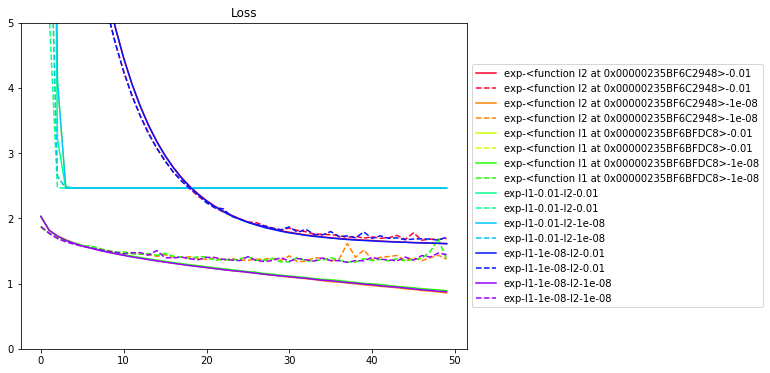

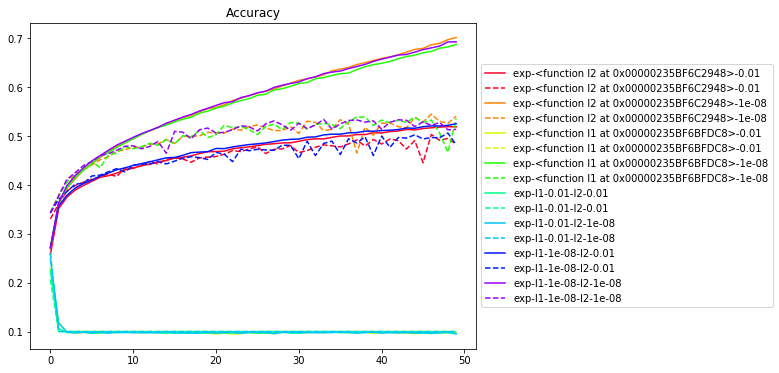

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()